# Prediction

## Load preprocessed dataframes

In [1]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

,loan_id,loan_amount,duration,payments,status,client_count,issuance_frequency_per_month,sex,age,account_age,days_since_last_transaction,reached_negative_balance
0,4959,80952,24,3373,1,2,1.000000,1,53,313,5,False
1,4961,30276,12,2523,-1,1,1.000000,0,59,388,19,False
2,4973,165960,24,6915,1,1,1.000000,0,54,561,2,False
3,4996,88440,12,7370,1,2,13.044643,0,53,179,6,False
4,5002,104808,12,8734,1,2,1.000000,1,59,186,6,False


## Columns to drop and feature target

In [2]:
columns_to_drop = ["loan_id", "status"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,loan_amount,duration,payments,client_count,issuance_frequency_per_month,sex,age,account_age,days_since_last_transaction,reached_negative_balance
0,80952,24,3373,2,1.000000,1,53,313,5,False
1,30276,12,2523,1,1.000000,0,59,388,19,False
2,165960,24,6915,1,1.000000,0,54,561,2,False
3,88440,12,7370,2,13.044643,0,53,179,6,False
4,104808,12,8734,2,1.000000,1,59,186,6,False


## Tune Models

### Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

# No feature selection
dt = tune_model(
    train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=True
)

plot_tree(dt.best_estimator_);

ValueError: Invalid parameter decisiontreeclassifiercriterion for estimator Pipeline(steps=[('sampling', SMOTE()), ('model', DecisionTreeClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

### SVM
Needs to be scaled (StandardScaler)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    # 'kernel': ['linear', 'poly', 'rbf']
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# No feature selection
svc = tune_model(
    train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

svc.best_estimator_

KeyboardInterrupt: 

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [ ]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

# No feature selection
knn = tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.7916656403940886
Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 5}


### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

# No feature selection
nb = tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.830018472906404
Best parameters: {}


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

# No feature selection
rfc = tune_model(
    train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column
)

Best score: 0.8709051724137931
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1}


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

parameter_grid = {
    "max_iter": [1000, 5000, 10000]
}

lr = tune_model(
    train_df,
    LogisticRegression(),
    parameter_grid,
    columns_to_drop,
    target_column
)

Best score: 0.5697229064039409
Best parameters: {'max_iter': 1000}


## Comparing Models

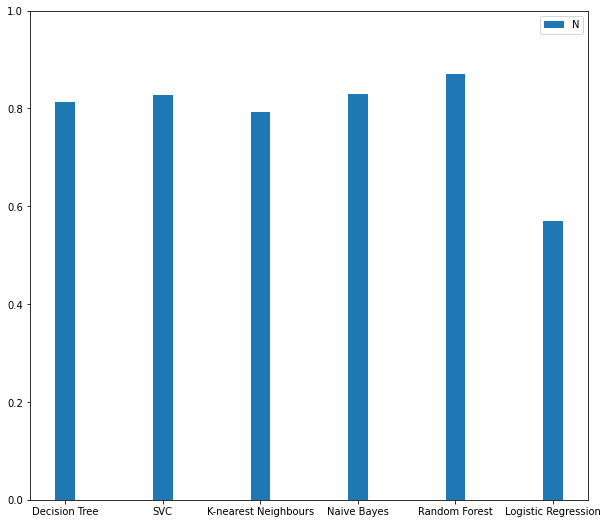

In [ ]:
scores = {
    "Decision Tree" : [dt], #[dt_original, dt, dt_os_fs],
    "SVC" : [svc], #[svc_original, svc, svc_os_fs],
    "K-nearest Neighbours" : [knn], #[knn_original, knn, knn_os_fs],
    "Naive Bayes" : [nb], #[nb_original, nb, nb_os_fs],
    "Random Forest" : [rfc], #[rfc_original, rfc, rfc_os_fs]
    "Logistic Regression": [lr]
}

labels = "No Feature selection" # ["No oversampling/No feature selection","No oversampling/Feature selection", "Oversampling/Feature selection"]

ind = np.arange(6)

plt.figure(figsize=(10,9))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
plt.xticks(ind, scores.keys())
plt.legend(labels, loc=1)
plt.ylim(0, 1)
plt.show()

## Save results

In [ ]:
X_result = test_df.drop(columns_to_drop, axis=1)

y_result = rfc.predict_proba(X_result)[:, 1]

result = pd.DataFrame({"Id": test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)